# Objectivo 1: lectura y tratamiento

Lectura de datos asociados a la calidad del aire del año 2018 en Madrid.

In [5]:
# Import libraries
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt

In [6]:
# Read all the CSV files and join them creating a Dataframe
df = pd.DataFrame()
for _file in os.listdir(r'data'):
    df = pd.concat([df, pd.read_csv('data\\' + _file, sep=';', dtype=str)])

Sólo nos interesan los niveles de NO<sup>2</sup>, por lo tanto se puede filtar el Dataframe para reducir el número de filas. Como se describe en la documentación, dichos niveles corresponde al código '08' de la columna 'MAGNITUD'.

In [7]:
# Filter the dataframe
df = df[df['MAGNITUD'] == '8'].reset_index(drop=True)

Además existen una serie de columnas que indican si un dato es válido o no (VX, siendo X la hora de escritura del dato). Por lo tanto es necesario hacer una comprobación previa.

In [8]:
def validate_data(x):
    """
    Check the value of VX column. If is different than 'V', modify the HX value to null.

    Args:
        x (Pandas Series): Row of the dataframe

    Return:
          Pandas Series: Modify row of the dataframe
    """

    # Create a list with the columns names
    columns = ['V0{}'.format(i) if i < 10 else 'V{}'.format(i) for i in range(1,25)]
    for column in columns:
        # Evaluate each column value
        if x[column] != 'V':
            # If not is 'V' change the HX column to 'null'
            x['H'+column[1:]] = 'null'
            
    return x

In [9]:
# Validate the VX columns
df = df.apply(lambda row: validate_data(row), axis=1)

In [10]:
df

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,28,079,4,8,28079004_8_8,2018,04,01,00021,V,...,00046,V,00057,V,00082,V,00085,V,00077,V
1,28,079,4,8,28079004_8_8,2018,04,02,00067,V,...,00022,V,00026,V,00038,V,00015,V,00015,V
2,28,079,4,8,28079004_8_8,2018,04,03,00014,V,...,00023,V,00027,V,00030,V,00023,V,00020,V
3,28,079,4,8,28079004_8_8,2018,04,04,00008,V,...,00014,V,00019,V,00022,V,00028,V,00023,V
4,28,079,4,8,28079004_8_8,2018,04,05,00020,V,...,00045,V,00068,V,00099,V,00093,V,00084,V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8745,28,079,60,8,28079060_8_8,2018,09,26,00016,V,...,00047,V,00026,V,00017,V,00015,V,00013,V
8746,28,079,60,8,28079060_8_8,2018,09,27,00009,V,...,00028,V,00047,V,00071,V,00109,V,00074,V
8747,28,079,60,8,28079060_8_8,2018,09,28,00086,V,...,00026,V,00073,V,00120,V,00129,V,00116,V
8748,28,079,60,8,28079060_8_8,2018,09,29,00062,V,...,00020,V,00052,V,00093,V,00097,V,00102,V


A continuación es necesario modificar la estructura de la tabla para crear una serie temporal y poder observar de manera correcta los datos. Para ello se realizará una operación de pivote entre columnas y filas.

In [11]:
# Concatenate columns for complete date
df['date'] = df[['DIA', 'MES','ANO']].agg('/'.join, axis=1)
# Select the hours columns and the date new column
columns = ['H0{}'.format(i) if i < 10 else 'H{}'.format(i) for i in range(1,25)]
columns.append('date')
df = df[columns].copy()

In [12]:
# Pivot the columns to rows
df = df.melt(id_vars=['date'], var_name='hour', value_name='NO2')
# Filter the invalid values
df = df[df['NO2'] != 'null']
# Create new datetime column with the date and the hours
df['timestamp'] = pd.to_datetime(df['date'], format='%d/%m/%Y') + pd.to_timedelta(df['hour'].str[1:]                    .astype(int), unit='h')
# Select the necessary columns
df = df[['timestamp', 'NO2']]
# Change to integer the values
df['NO2'] = df['NO2'].astype(int)
# Set new index
df = df.set_index(pd.DatetimeIndex(df['timestamp']))
df = df.drop(columns=['timestamp'])

In [13]:
df

,NO2
timestamp,
2018-04-01 01:00:00,21
2018-04-02 01:00:00,67
2018-04-03 01:00:00,14
2018-04-04 01:00:00,8
2018-04-05 01:00:00,20
...,...
2018-09-27 00:00:00,13
2018-09-28 00:00:00,74
2018-09-29 00:00:00,116


<AxesSubplot:title={'center':'Evolución NO2 Madrid 2018'}, xlabel='timestamp', ylabel='NO2 (um/g3)'>

<Figure size 432x288 with 0 Axes>

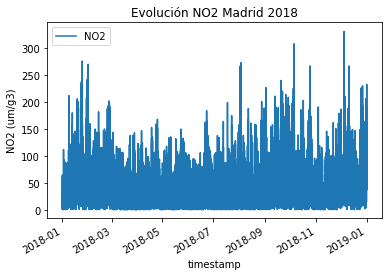

In [14]:
plt.figure()
df.plot(title='Evolución NO2 Madrid 2018', ylabel='NO2 (um/g3)')

# Objetivo 2: Arquitectura

La arquitectura propuesta para implemnetar el sistema es la siguiente.

![](indigital_arquitectura.png)

La idea principal es almacenar toda la información en una base de datos para después poder consultarla para cada una de las acciones requeridas (análisis de datos, predicción para el usuario,...). Con unos cálculos rápidos se puede estimar la necesidad de espacio para la base de datos: cada día se recogen 24 datos nuevos (teniendo sólo en cuenta el dato de NO<sup>2</sup>), y sabiendo que existen datos desde 2001, esto resultan en 24*365*20 = 175.200 datos que almacenar (2021). Para las necesidades de la aplicación se ha decido usar una base de datos NoSQL ya que proporcionada más rapidez de lectura y escritura y no es necesario tener un modelo de los datos. 

MongoDB puede ser una buena opción ya que los ficheros BSON de los que hace uso no requiere un gran espacio de almacenamiento aunque, si fuera necesario, este tipo de sistemas poseen una gran capacidad de escalado.

Los datos en tiempo real se pueden descargar haciendo uso de un sencillo programa de scraping en Python que se ejecute cada hora para actualizar la base de datos. Podría desplegarse en una máquina virtual en la nube mediante un contenedor docker, junto con la llamada a la API de la temperatura de la ciudad de Madrid y la unión de todos los datos para la posterior ingesta en la base de datos.

La estructura del JSON final podría ser:

```
{
    timestamp: 2018-04-01 01:00:00,
    estacion_id: 28079004,
    no2: 102,
    temperatura: 19
}
```

Con los datos históricos en la base de datos es posible crear un modelo capaz de predecir los niveles de NO<sup>2</sup> y la temperatura de la ciudad. Este modelo podría ser implementado en Python haciendo uso de las redes neuronales Long Short-Term Memory (LSTM), que no son más que redes neuronales que tienen en cuenta la salida anterior en el proceso de aprendizaje. 

Este modelo estará conectado al Front, dónde el usuario final será capaz de interactuar con él y realizar consultas de predicción a varios días vista. Además también se implementará una API para que el modelo sea fácilmente integrable en otros sistemas. El front puede ser programado en algún framework como Flask o Django y puede contener visualizaciones de los datos. Esta página también dispondrá de una subida de datos a Mongo para los administradores para cargas puntuales. Flask y Django proporcionan una forma sencilla de desplegar el sistema en un servidor en la nube.

Por último, será posible la lectura de la base de datos para realizar otros estudios futuros.